In [1]:
!pip install image-classifiers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image

2024-05-08 09:15:16.630680: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 09:15:16.630776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 09:15:16.779232: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_path= '../input/thermography-images-of-diabetic-foot/ThermoDataBase/train'
test_path='../input/thermography-images-of-diabetic-foot/ThermoDataBase/val'

In [4]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split =0.2
)
test_datagen= image.ImageDataGenerator(   
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (224,224),
    batch_size = 4,
    class_mode = 'binary',
    subset='training'
)
val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (224,224),
    batch_size = 4,
    class_mode = 'binary',
    subset='validation'
)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size = (224,224),
    batch_size = 4,
    shuffle=True,
    class_mode = 'binary')

Found 1156 images belonging to 2 classes.
Found 288 images belonging to 2 classes.
Found 422 images belonging to 2 classes.


In [6]:
from classification_models.tfkeras import Classifiers

In [7]:
SeResNext101, preprocess_input = Classifiers.get("seresnext101")

In [8]:
base_model = SeResNext101(weights='imagenet', input_shape=(224,224,3), include_top=False)
# Freeze layers
for layer in base_model.layers:
    layer.trainable=False
model = Sequential()
model.add(base_model)
model.add(GaussianNoise(0.25))
model.add(GlobalAveragePooling2D())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.25))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.summary()

192995976/192995976 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_1 (Functional)       │ ?                      │    47,044,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_33     │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_104         │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_1                │ ?                      │   0 (unbuilt) │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,044,272 (179.46 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 47,044,272 (179.46 MB)

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer='adamw',
              metrics=['accuracy','AUC','Precision','Recall'])

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath='best_model.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    steps_per_epoch= 50,
    callbacks=[checkpoint]
    )

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1715159850.577362     126 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 3/50 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - AUC: 0.5802 - Precision: 0.1667 - Recall: 0.2333 - accuracy: 0.3889 - loss: 0.9684  

W0000 00:00:1715159850.964994     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - AUC: 0.5563 - Precision: 0.5114 - Recall: 0.5083 - accuracy: 0.5167 - loss: 0.8869

W0000 00:00:1715159893.292670     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.65625, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - AUC: 0.5573 - Precision: 0.5129 - Recall: 0.5101 - accuracy: 0.5179 - loss: 0.8854 - val_AUC: 0.7150 - val_Precision: 0.6667 - val_Recall: 0.6250 - val_accuracy: 0.6562 - val_loss: 0.9670
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - AUC: 0.6889 - Precision: 0.6077 - Recall: 0.5846 - accuracy: 0.5762 - loss: 0.7009
Epoch 2: val_accuracy did not improve from 0.65625
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - AUC: 0.6888 - Precision: 0.6071 - Recall: 0.5850 - accuracy: 0.5768 - loss: 0.7009 - val_AUC: 0.7918 - val_Precision: 0.5204 - val_Recall: 0.9722 - val_accuracy: 0.5382 - val_loss: 1.2074
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - AUC: 0.6686 - Precision: 0.6835 - Recall: 0.6162 - accuracy: 0.6339 - loss: 0.6992
Epoch 3: val_accuracy improved from 0.65625 to 0.66319, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 251ms/ste

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 6: val_accuracy improved from 0.73611 to 0.77431, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 237ms/step - AUC: 0.7292 - Precision: 0.6932 - Recall: 0.6486 - accuracy: 0.6889 - loss: 0.6287 - val_AUC: 0.8087 - val_Precision: 0.8835 - val_Recall: 0.6319 - val_accuracy: 0.7743 - val_loss: 0.6156
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - AUC: 0.7720 - Precision: 0.6340 - Recall: 0.7087 - accuracy: 0.6678 - loss: 0.5816
Epoch 7: val_accuracy did not improve from 0.77431
50/50 ━━━━━━━━━━━━━━━━━━━━ 47s 146ms/step - AUC: 0.7700 - Precision: 0.6336 - Recall: 0.7068 - accuracy: 0.6669 - loss: 0.5840 - val_AUC: 0.8307 - val_Precision: 0.8462 - val_Recall: 0.5347 - val_accuracy: 0.7188 - val_loss: 0.5770
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - AUC: 0.6326 - Precision: 0.6403 - Recall: 0.5511 - accuracy: 0.5778 - loss: 0.7657
Epoch 8: val_accuracy did not improve from 0.77431
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - AUC: 0.6324 - Precision: 0.63

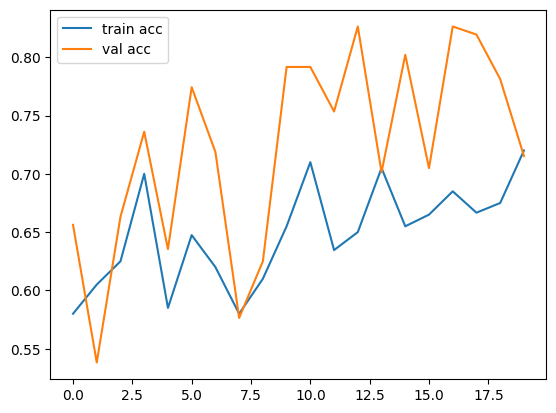

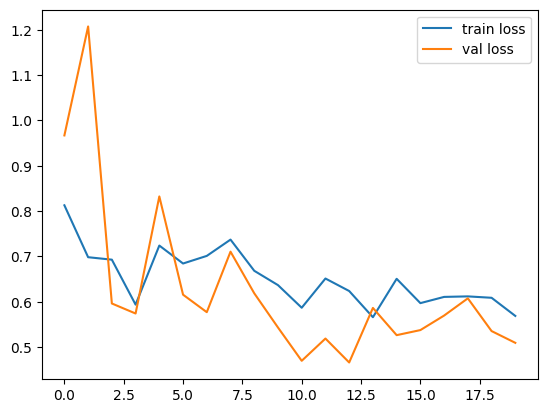

In [11]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('SeResNext101-acc.png')
plt.show()
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('SeResNext101-loss.png')
plt.show()

In [12]:
model.evaluate(test_generator)


106/106 ━━━━━━━━━━━━━━━━━━━━ 31s 299ms/step - AUC: 0.8430 - Precision: 0.8237 - Recall: 0.7683 - accuracy: 0.7489 - loss: 0.5213


[0.5573598742485046,
 0.7322275042533875,
 0.8105275630950928,
 0.7883817553520203,
 0.7539682388305664]

1/1 ━━━━━━━━━━━━━━━━━━━━ 38s 38s/step
[[0.39491844]]
THE UPLOADED THERMAL IMAGE IS SUSPECTED AS: Normal


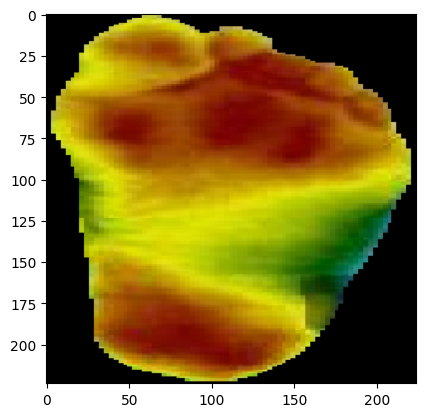

In [13]:
from tensorflow.keras.utils import load_img, img_to_array
img = load_img('../input/thermography-images-of-diabetic-foot/ThermoDataBase/val/DM Group/DM004_M_L.png',target_size=(224,224))
imag = img_to_array(img)
imaga = np.expand_dims(imag,axis=0) 
ypred = model.predict(imaga)
print(ypred)
a=ypred[0]
if a<0.5:
      op="Normal"   
else:
      op="Diabetic"
plt.imshow(img)
print("THE UPLOADED THERMAL IMAGE IS SUSPECTED AS: "+str(op))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
[[0.3228137]]
THE UPLOADED THERMAL IMAGE IS SUSPECTED AS: Normal


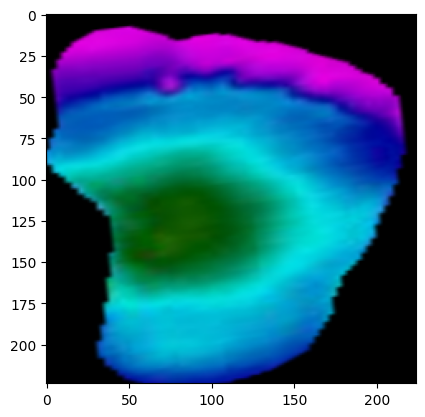

In [14]:
from tensorflow.keras.utils import load_img, img_to_array
img = load_img('/kaggle/input/thermography-images-of-diabetic-foot/ThermoDataBase/val/Control Group/CG001_M_L-rotated1-rotated1.png',target_size=(224,224))
imag = img_to_array(img)
imaga = np.expand_dims(imag,axis=0) 
ypred = model.predict(imaga)
print(ypred)
a=ypred[0]
if a<0.5:
      op="Normal"   
else:
      op="Diabetic"
plt.imshow(img)
print("THE UPLOADED THERMAL IMAGE IS SUSPECTED AS: "+str(op))